In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from NEID_solar_functions import *
from GP_kernels import *

# SONG RVs

In [2]:
SONG = np.loadtxt('./lib/sun_SONG_full_lowess_filtered_final_used.dat')
bjd = SONG[:,0]
rv = SONG[:,1]

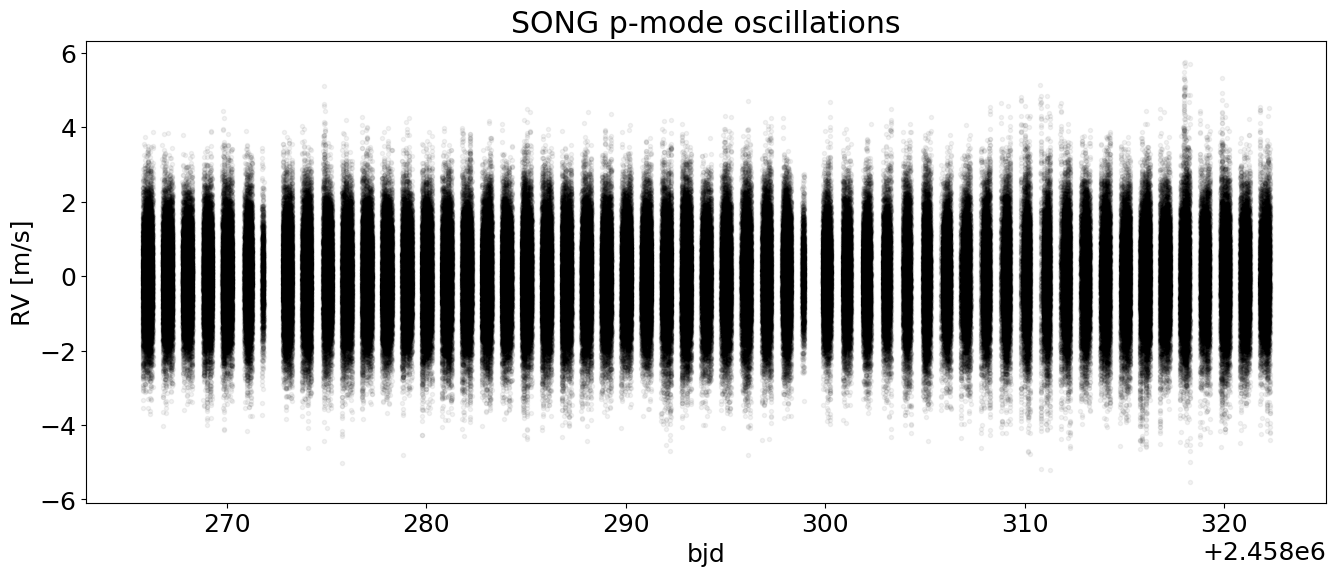

In [3]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.xlabel('bjd')
plt.ylabel('RV [m/s]')
plt.title('SONG p-mode oscillations')
plt.plot(bjd, rv, 'k.', alpha=0.05)
plt.savefig('./Figure/SONG_p_mode.png')

In [4]:
pyasl.daycnv(min(bjd)), pyasl.daycnv(max(bjd))

([2018, 5, 27, 6.777839999645948], [2018, 7, 22, 19.03991999477148])

In [5]:
start_date = datetime(2018, 5, 27)
# end_date = datetime(2018, 5, 27)
end_date = datetime(2018, 7, 22)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    
    fig = plt.figure(figsize=(16, 9))
    plt.title(str(date)[:10])
    plt.plot(t, y, 'k.', alpha=0.3)
    plt.xlim([-10, 760])
    plt.ylim([-5, 5])
    plt.xlabel('$t$ [minutes]')
    plt.ylabel('RV [m/s]')
    plt.savefig('./Figure/Daily_RV/RV_' + str(date)[:10] + '.png', dpi=300)
    plt.close()

In [6]:
import cv2
import glob

img_array = []
for filename in glob.glob('./Figure/Daily_RV/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./Video/Daily_RV.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# Estimate RV uncertainty

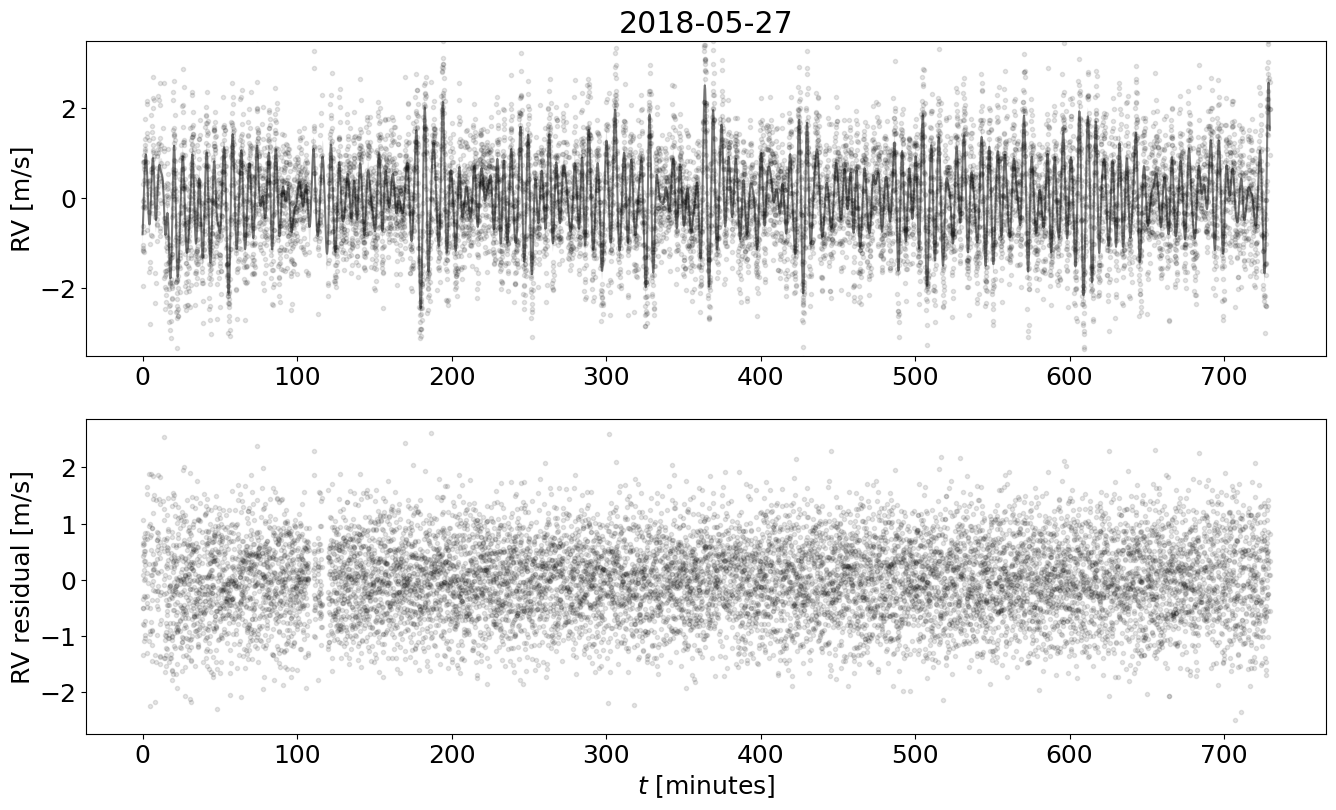

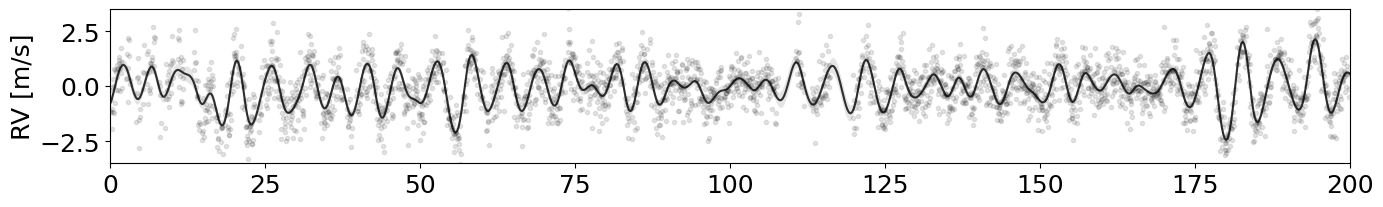

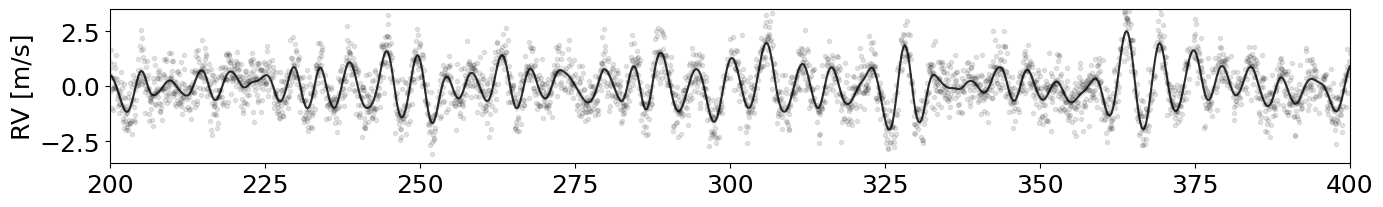

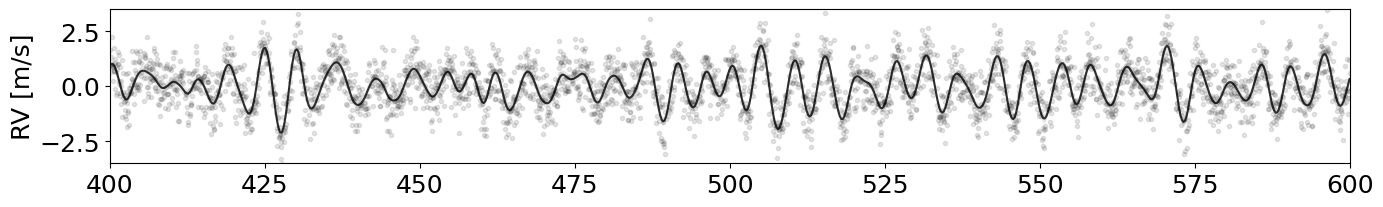

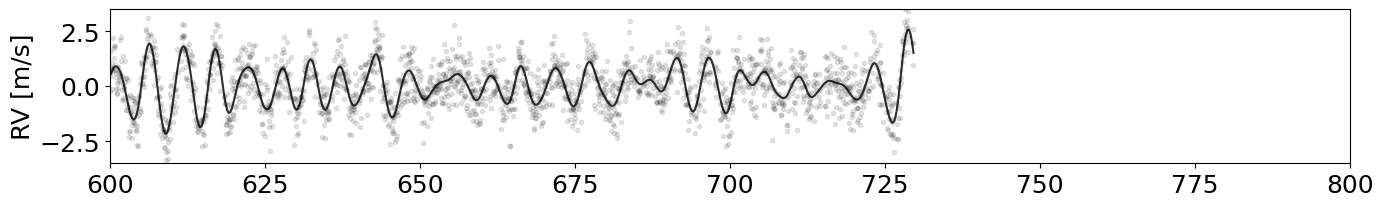

In [7]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*1
    
    gp = GP_fit_p1(t, y, yerr, p=5.37)
    
    
    fig = plt.figure(figsize=(16, 9))
    fig.add_subplot(211)
    plt.title(str(date)[:10])
    plt.plot(t, y, 'k.', alpha=0.1)
    x = np.linspace(min(t), max(t), 3000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)        
    plt.plot(x, pred_mean, color='k', alpha=0.5)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                     edgecolor="none")
    plt.ylabel('RV [m/s]')
    plt.ylim([-3.5, 3.5])

    fig.add_subplot(212)
    pred_mean_t, pred_var = gp.predict(y, t, return_var=True)
    plt.plot(t, y-pred_mean_t, 'k.', alpha=0.1)
    plt.xlabel('$t$ [minutes]')
    plt.ylabel('RV residual [m/s]')
    plt.show()

for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8)
    plt.fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.1,
                     edgecolor="none")
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-3.5, 3.5])
    plt.show()

exposure spacing in seconds

In [8]:
np.median(np.diff(t)*60)

3.4559860825538635

In [9]:
np.std(y-pred_mean_t)

0.699817978696215

# update RV uncertainty in yerr

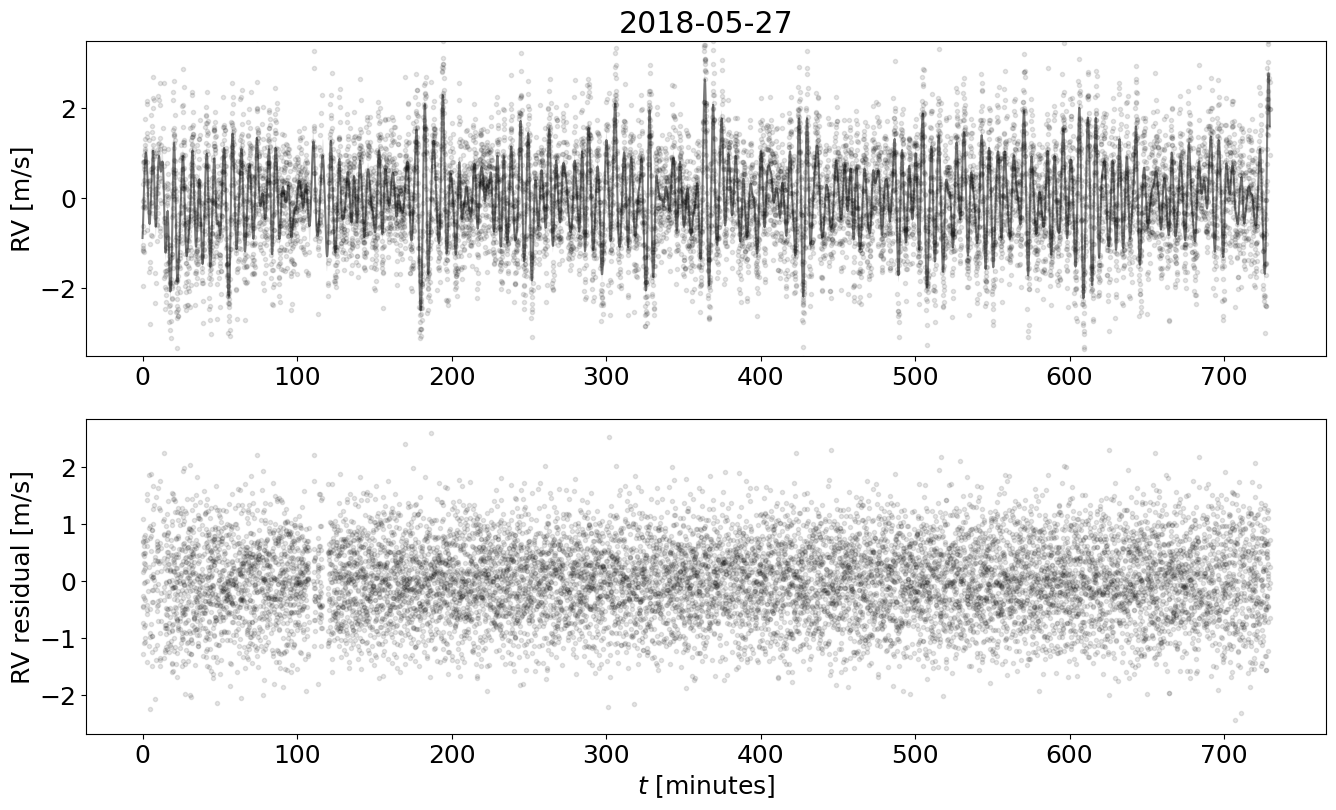

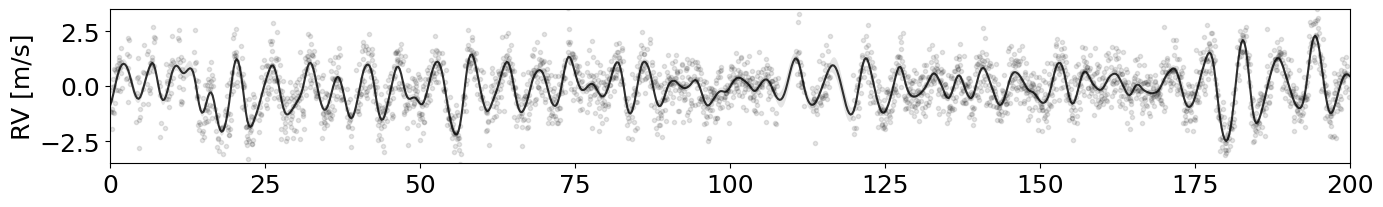

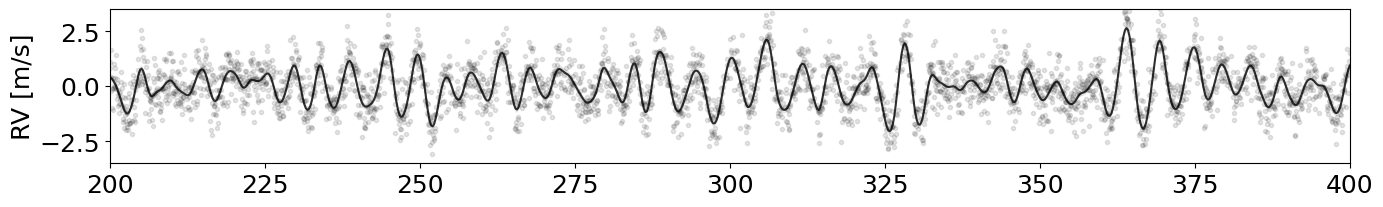

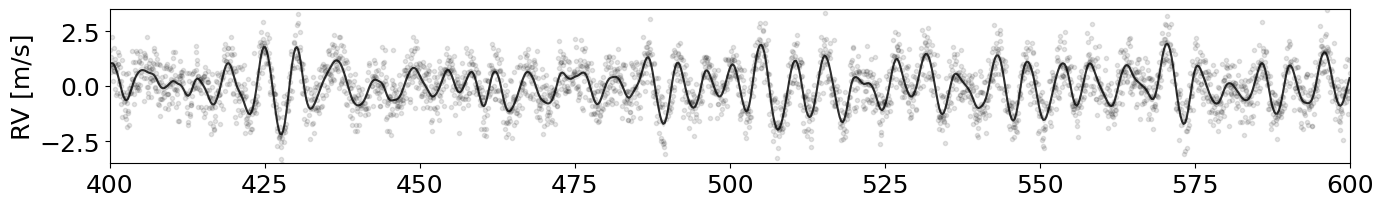

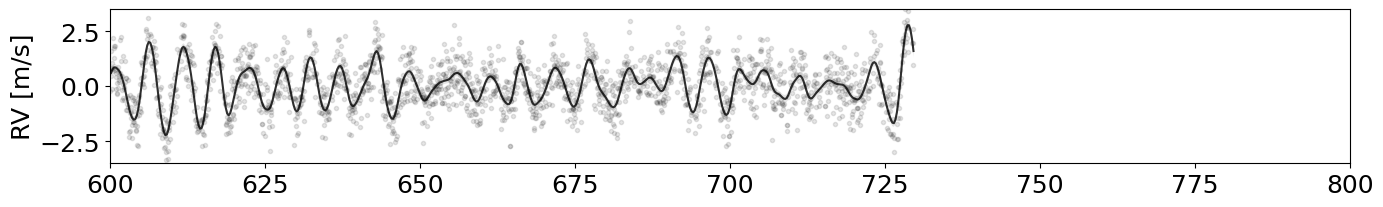

In [10]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*0.7
    
    gp = GP_fit_p1(t, y, yerr, p=5.37)
    
    
    fig = plt.figure(figsize=(16, 9))
    fig.add_subplot(211)
    plt.title(str(date)[:10])
    plt.plot(t, y, 'k.', alpha=0.1)
    x = np.linspace(min(t), max(t), 3000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)        
    plt.plot(x, pred_mean, color='k', alpha=0.5)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                     edgecolor="none")
    plt.ylabel('RV [m/s]')
    plt.ylim([-3.5, 3.5])

    fig.add_subplot(212)
    pred_mean_t, pred_var = gp.predict(y, t, return_var=True)
    plt.plot(t, y-pred_mean_t, 'k.', alpha=0.1)
    plt.xlabel('$t$ [minutes]')
    plt.ylabel('RV residual [m/s]')
    plt.show()

for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8)
    plt.fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.1,
                     edgecolor="none")
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-3.5, 3.5])
    plt.show()

In [11]:
np.std(y-pred_mean_t)

0.6878582614986558

# Test different approaches of calculating Cov

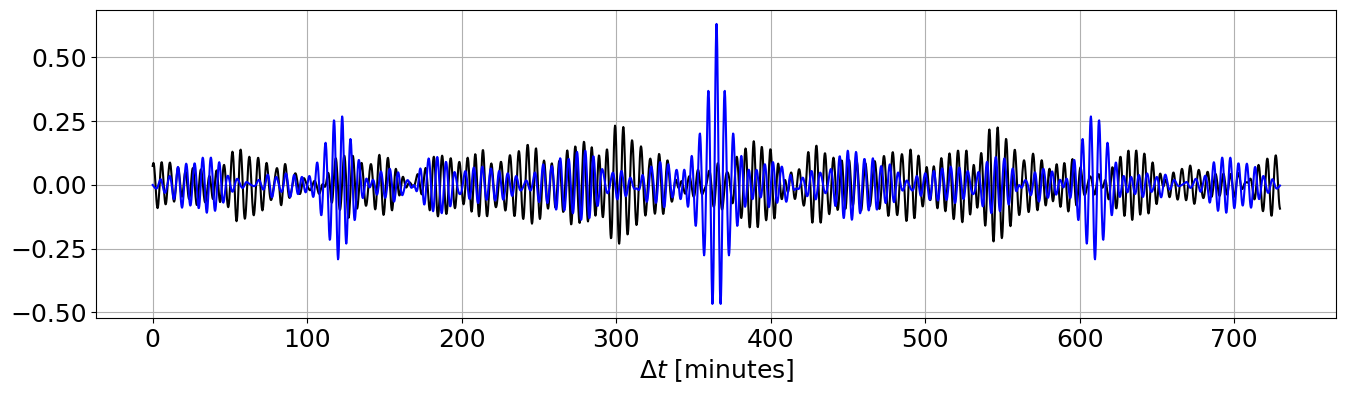

In [13]:
fig = plt.figure(figsize=(16, 4))
plt.plot(x, np.convolve(pred_mean, pred_mean, 'same')/len(x), 'k')
plt.grid()

from scipy import signal
corr = signal.correlate(pred_mean, pred_mean, mode='same') / len(pred_mean)
plt.xlabel(r'$\Delta t$ [minutes]')
plt.plot(x, corr, 'b')

### ACF is normalised 
https://www.sciencedirect.com/topics/chemistry/autocorrelation-function#:~:text=1%20Autocorrelation-,The%20autocorrelation%20function%20(ACF)%20defines%20how%20data%20points%20in%20a,signal%20over%20different%20delay%20times.

1.0

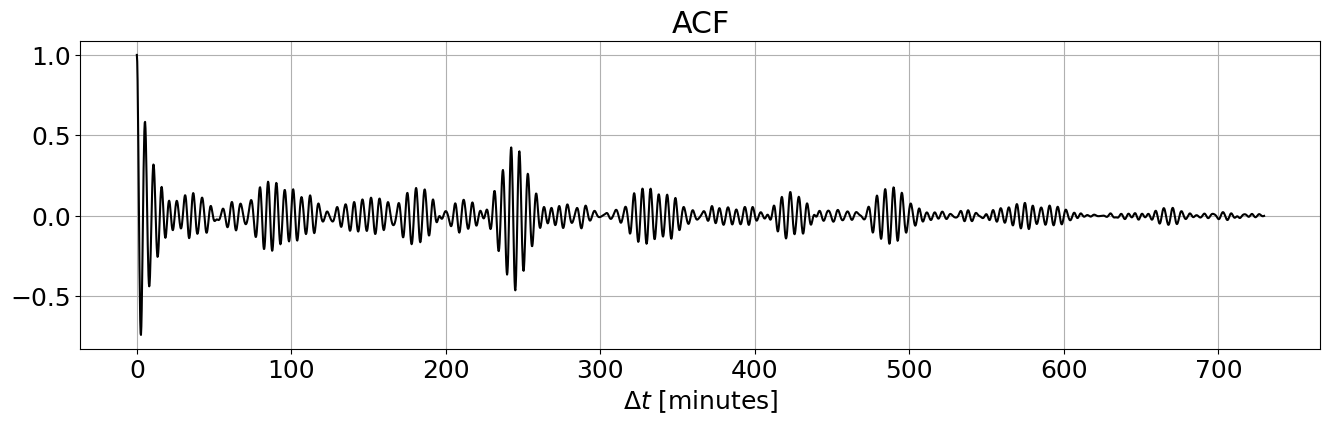

In [14]:
import statsmodels.api as sm
fig = plt.figure(figsize=(16, 4))
plt.plot(x, sm.tsa.acf(pred_mean, nlags=len(pred_mean), fft=True), 'k')
plt.title('ACF')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.grid()
sm.tsa.acf(pred_mean, nlags=len(pred_mean), fft=True)[0]

### acovf
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acovf.html

array([0.63013266, 0.63013266, 0.63013266, ..., 0.63013266, 0.63013266,
       0.63013266])

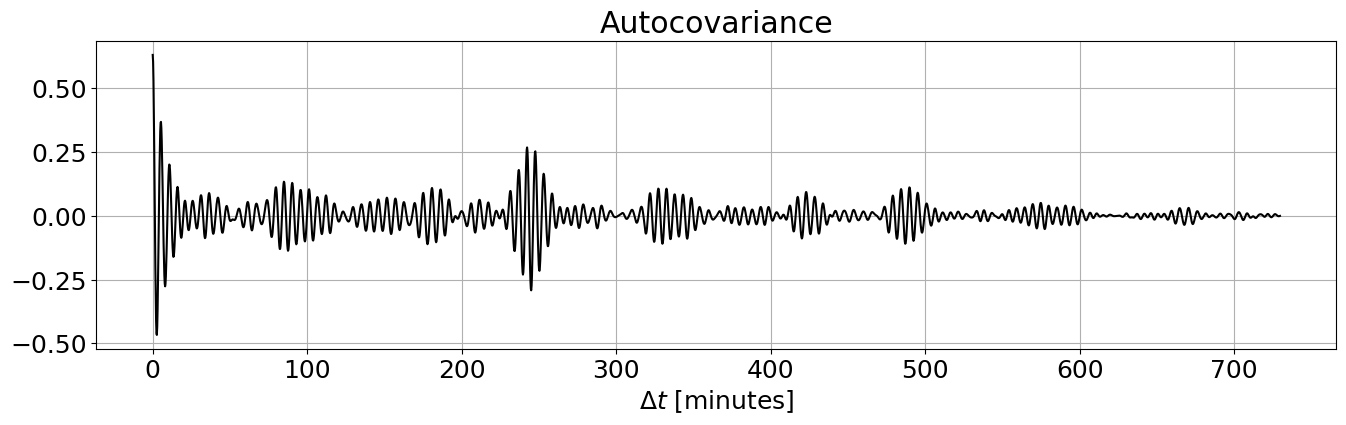

In [15]:
fig = plt.figure(figsize=(16, 4))
plt.plot(x, sm.tsa.acovf(pred_mean, fft=True), 'k')
plt.title('Autocovariance')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.grid()
sm.tsa.acovf(pred_mean, fft=True)/sm.tsa.acf(pred_mean, nlags=len(pred_mean), fft=True)

#### Autocovariance
https://en.wikipedia.org/wiki/Autocovariance
#### Autocorrelation    
https://en.wikipedia.org/wiki/Autocorrelation

### Covariance (Attention: very slow due to looping for gp!)

In [18]:
cov_XY = []
Delta_t = np.linspace(min(t), max(t)-1, 1000)
for delta_t in Delta_t:
    t_cov = np.linspace(0, max(t)-delta_t, int(max(t)-delta_t)+1)
    X, _ = gp.predict(y, t_cov, return_var=False)
    Y, _ = gp.predict(y, t_cov+delta_t, return_var=False)
    cov_XY.append(cov(X, Y))
cov_XY = np.array(cov_XY)

In [ ]:
fig = plt.figure(figsize=(16, 4))
plt.plot(Delta_t, cov_XY, 'k-', alpha=0.5, label='Covariance')
plt.plot(x, sm.tsa.acovf(pred_mean, fft=True), 'r', alpha=0.5, label='acovf')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Cov(RV$_t$, RV$_{t+\Delta t}$)')
plt.ylim([-0.7, 1.2])
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(16, 4))
plt.plot(Delta_t, cov_XY, 'k-', alpha=0.5, label='Covariance')
plt.plot(x, sm.tsa.acovf(pred_mean, fft=True)/(1-x/max(x)), 'b', alpha=0.5, label='acovf-denormalise')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Cov(RV$_t$, RV$_{t+\Delta t}$)')
plt.ylim([-0.7, 1.2])
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 4))

Delta_t = np.linspace(0, 600, 601)
pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))
plt.plot(Delta_t, ACF, 'k', alpha=0.5, label='600 min data')

Delta_t = np.linspace(0, 700, 701)
pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))
plt.plot(Delta_t, ACF, 'b', alpha=0.5, label='700 min data')

Delta_t = np.linspace(0, max(t), 701)
pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))
plt.plot(Delta_t, ACF, 'r', alpha=0.5, label='730 min data')

plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Cov(RV$_t$, RV$_{t+\Delta t}$)')
# plt.ylim([-0.7, 1.2])
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 4))

Delta_t = np.arange(0, max(t), step=0.5)
pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))
plt.plot(Delta_t, ACF, 'k', label='step=0.5')

Delta_t = np.arange(0, max(t), step=1)
pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))
plt.plot(Delta_t, ACF, 'b', label='step=1')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Cov(RV$_t$, RV$_{t+\Delta t}$)')
plt.ylim([-0.7, 1.2])
plt.legend()
plt.grid()
plt.show()

# Daily Covariance 

In [12]:
f0 = [2228.779, 2362.831, 2496.237, 2629.741, 2764.233, 2899.133, 3033.886, 3168.773, 3303.698, 3439.195, 3575.121, 3710.972, 3847.277, 3984.527, 3984.527+137.25, 3984.527+137.25*2]
f1 = [2292.035, 2425.655, 2559.242, 2693.450, 2828.279, 2963.478, 3098.327, 3233.358, 3368.721, 3504.417, 3640.799, 3777.430, 3913.974, 3913.974+136.544, 3913.974+136.544*2]
freq = np.hstack((np.array(f0), np.array(f1)))

def plot_osc_freq():
    alpha = 0.5
    for x in f0:
        plt.axvline(x = x, color = 'b', alpha=alpha, label=r'$l=0$' if x==f0[0] else '')
    for x in f1:
        plt.axvline(x = x, color = 'r', alpha=alpha, label=r'$l=1$' if x==f1[0] else '')
    plt.legend()

### Auto-Covariance using sm.tsa.acovf (a lot faster!)

In [22]:
import statsmodels.api as sm
from astropy.timeseries import LombScargle

start_date = datetime(2018, 5, 27)
# end_date = datetime(2018, 5, 27)
end_date = datetime(2018, 7, 22)

Cov_XYs = []

for date in daterange(start_date, end_date):
    
    print(str(date)[:10])

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)

    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    delta_t = max(t) - min(t)

    if delta_t>600:

        y = rv[idx_bjd]
        yerr = np.ones(len(t))*0.5
        gp = GP_fit_p1(t, y, yerr, p=5.37)

        fig = plt.figure(figsize=(16, 9))
        plt.subplots_adjust(right=0.85, hspace=0.4)
        plt.rcParams.update({'font.size': 14})

        ## Upper panel
        fig.add_subplot(311)
        plt.title(str(date)[:10])
        plt.plot(t, y, 'k.', alpha=0.1)
        x = np.linspace(min(t), max(t), 2000)
        pred_mean, pred_var = gp.predict(y, x, return_var=True)
        pred_std = np.sqrt(pred_var)
        plt.plot(x, pred_mean, color='k', alpha=0.5)
        plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                         edgecolor="none")
        plt.xlabel('$t$ [minutes]')
        plt.ylabel('RV [m/s]')
        plt.xlim([-10, 760])
        plt.ylim([-3.5, 3.5])

        ## Middle panel
        fig.add_subplot(312)
#         frequency, power = LombScargle(t*60, y).autopower(minimum_frequency=1/800, maximum_frequency=1, samples_per_peak=100)
#         frequency *= 1e6
#         idx = ((frequency<4500) & (frequency>2000))
#         plt.plot(frequency[idx], power[idx], 'k')
        frequency, power = LombScargle(x*60, pred_mean).autopower(minimum_frequency=1/600, maximum_frequency=1/200, samples_per_peak=100)
        frequency *= 1e6
        idx = ((frequency<4500) & (frequency>2000))
        plt.plot(frequency[idx], power[idx], 'k')
        plt.xlabel(r'Frequency [$\mu$Hz]')
        plt.ylabel('Power')
        plt.ylim([0, 0.2])
        alpha=0.5
        if 0: # for quiet sun 
            for x in [2496.237, 2629.668, 2764.142, 2899.022, 3033.754, 3168.618, 3303.520, 3438.992, 3574.893, 3710.717, 3846.993, 3984.214]:
                plt.axvline(x = x, color = 'g', label='l=0', alpha=alpha)
            for x in [2559.242, 2693.347, 2828.150, 2963.322, 3098.140, 3233.139, 3368.469, 3504.129, 3640.475, 3777.067, 3913.570]:
                plt.axvline(x = x, color = 'r', label='l=1', alpha=alpha)
        plot_osc_freq()
        
        ## Lower panel
        fig.add_subplot(313)
        Delta_t = np.arange(0, max(t), step=0.5)
        cov_XY = []
        pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
        ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))
        plt.plot(Delta_t, ACF, 'k')
        plt.xlim([-10, 760])
        plt.ylim([-0.7, 0.7])

        if len(Cov_XYs) == 0:
            Cov_XYs = ACF[Delta_t<=600]
        else:
            Cov_XYs = np.vstack((Cov_XYs, ACF[Delta_t<=600]))

        plt.xlabel(r'$\Delta t$ [minutes]')
        plt.ylabel(r'Covariance [m$^2$/s$^2$]')
        plt.grid()
        plt.savefig('./Covariance/' + str(date)[:10] + '.png', dpi=300)
#         plt.show()
        plt.close()        

/tmp/ipykernel_282766/1423707536.py:69: RuntimeWarning: divide by zero encountered in divide
  ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))


In [23]:
img_array = []

for filename in glob.glob('./Covariance/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('Video/Covariance.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


### Same as above but skip the figures

In [13]:
import statsmodels.api as sm
from astropy.timeseries import LombScargle

start_date = datetime(2018, 5, 27)
# end_date = datetime(2018, 5, 27)
end_date = datetime(2018, 7, 22)

Cov_XYs = []

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)

    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    delta_t = max(t) - min(t)

    if delta_t>600:

        y = rv[idx_bjd]
        yerr = np.ones(len(t))*0.5
        gp = GP_fit_p1(t, y, yerr, p=5.37)
        Delta_t = np.arange(0, max(t), step=1)
        cov_XY = []
        pred_mean, pred_var = gp.predict(y, Delta_t, return_var=True)
        ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))

        if len(Cov_XYs) == 0:
            Cov_XYs = ACF[Delta_t<=600]
        else:
            Cov_XYs = np.vstack((Cov_XYs, ACF[Delta_t<=600]))

/tmp/ipykernel_3401980/1210431438.py:26: RuntimeWarning: divide by zero encountered in divide
  ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))


### Finally, plot the auto-covariance function

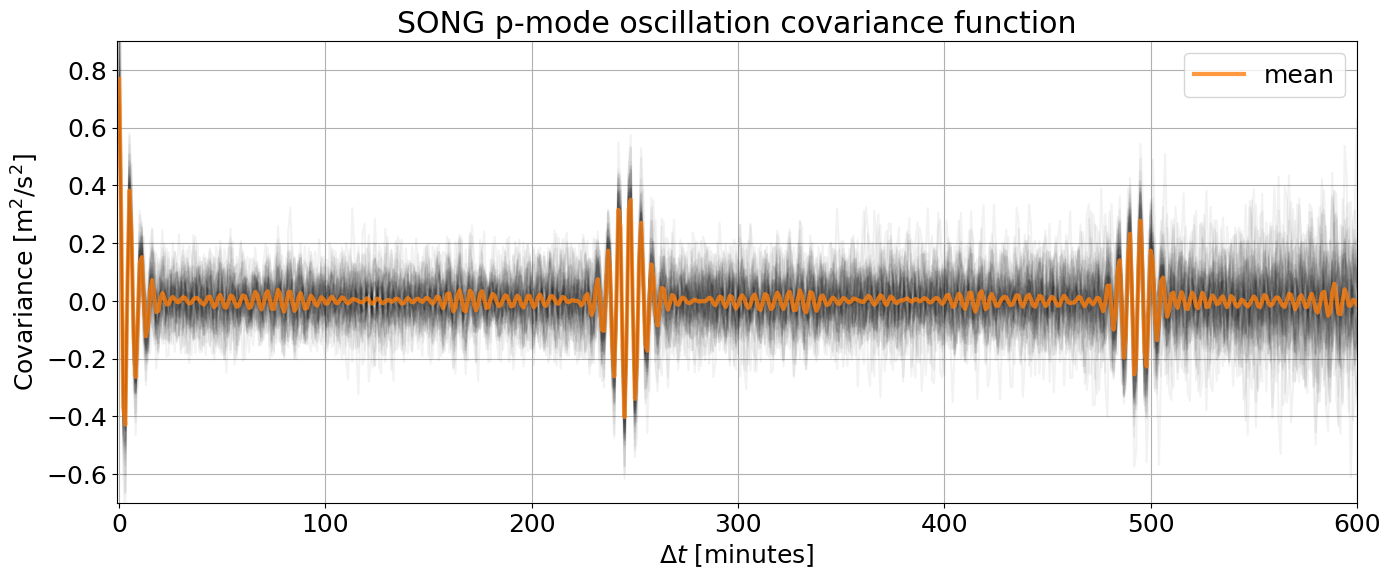

In [14]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(Delta_t[Delta_t<=600], Cov_XYs.T, 'k', alpha=0.05)
plt.plot(Delta_t[Delta_t<=600], np.mean(Cov_XYs, axis=0), lw=3, color='tab:orange', alpha=0.8, label='mean')
# plt.plot(Delta_t[Delta_t<=600], np.median(Cov_XYs, axis=0), lw=2, alpha=0.9, label='median')
plt.title('SONG p-mode oscillation covariance function')
plt.xlim([-1,600])
plt.ylim([-0.7,0.9])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.grid()
plt.savefig('./Figure/SONG_cov.png')
plt.show()

# Session 2: Study oscillation parameters in the auto-covariance space

### Try to recover the covariance above: too hard for now

In [31]:
import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import tinygp

jax.config.update("jax_enable_x64", True)

uHz_conv = 1e-6 * 60
amp0, mu0, sig0 = np.array([ 5.46875972e-03,  3.08082489e+03, 3.05370933e+02])    
amp0 *= 6e1
nu_max0 = mu0
delta_nu0 = 135
epsilon0 = 0
Q0 = 4e2
N0 = 25 # 25*135/2=1620

nu_max=nu_max0*0.9
delta_nu=delta_nu0
epsilon=epsilon0
Q=Q0
amp=amp0
sig=sig0
N=N0    
    
def gaussian_2(x, amp, mu, sig):
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) 

def kernel_function(*args):
    amp, Q = args
    kernel = 0  
    for i in range(3):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    return kernel

dx = Delta_t[Delta_t<=600]
def diff(*args):
    kernel = kernel_function(*args)
    return (np.array(kernel(dx, dx[:1])).T-np.mean(Cov_XYs, axis=0)).flatten()

def objective_function(*args):
    return sum(diff(*args)**2)


In [32]:
objective_function(amp0, 400)

3.159180748728889

In [35]:
from scipy.optimize import minimize
bounds = [(0,1), (200, 500)]
res = minimize(
    objective_function,
    x0=([amp0, 400]),
    args=(amp, Q,),
    # bounds=bounds,
)



ValueError: too many values to unpack (expected 2)

In [93]:
res

     fun: 2.343754455857678
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 15
     nit: 10
 success: True
       x: 2.696297201894996

2.696297201894996


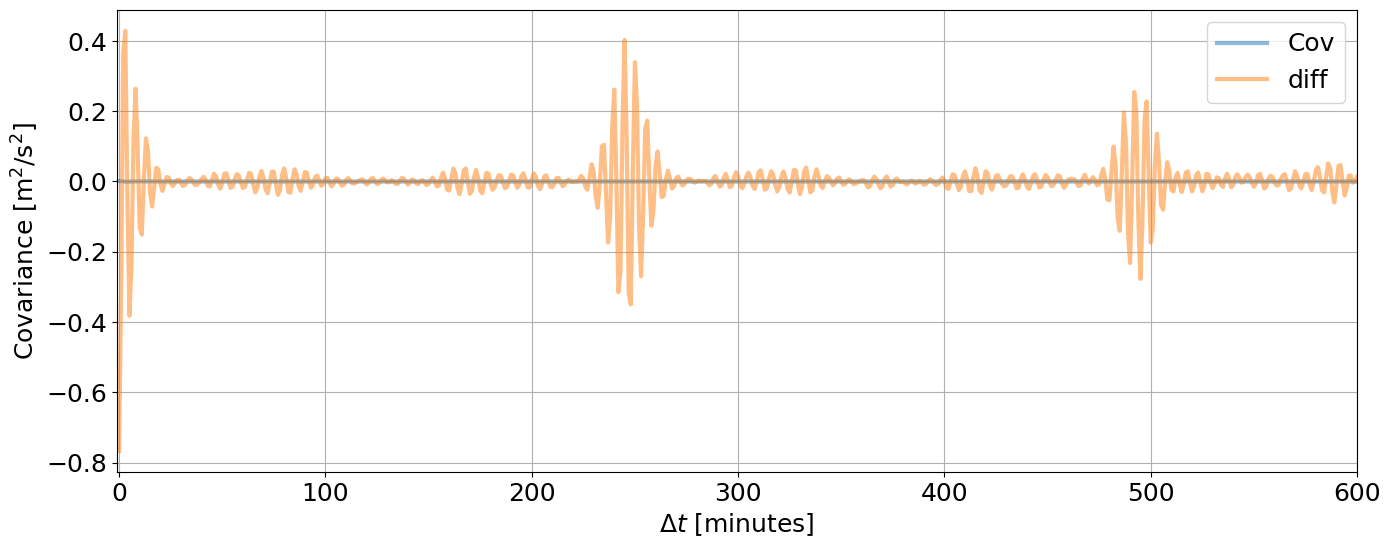

In [36]:
for Q in [2.696297201894996]:
    print(Q)
    fig = plt.figure(figsize=(16, 6))
    kernel = kernel_function(amp0, Q)
    plt.xlim([-1,600])
    plt.plot(dx, kernel(dx, dx[:1]), lw=3, alpha=0.5, label='Cov')
    plt.plot(dx, diff(amp0, Q), lw=3, alpha=0.5, label='diff')
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.grid()
    plt.legend()
    plt.show() 

1
10
100


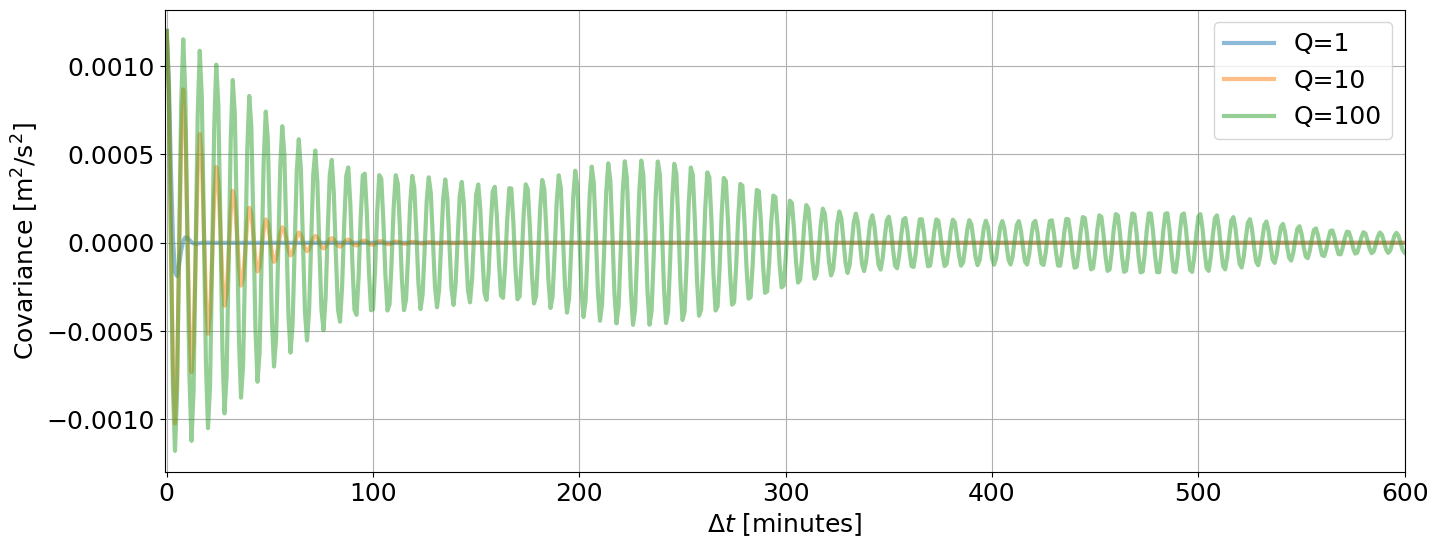

In [38]:
fig = plt.figure(figsize=(16, 6))
for Q in [1, 10, 100]:
    print(Q)
    kernel = kernel_function(amp0, Q)    
    dx = Delta_t[Delta_t<=600]
    plt.xlim([-1,600])
    plt.plot(dx, kernel(dx, dx[:1]), lw=3, alpha=0.5, label='Q={:d}'.format(Q))
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.grid()
    plt.legend()
plt.show() 


# The following is not so relevant for now

# periodogram

In [1]:
from scipy.interpolate import CubicSpline
         
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)
# end_date = datetime(2018, 7, 22)

Day = []
Date = []
power_matrix = np.array([])

fig = plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 16})
fig.add_subplot(211)

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)

    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    delta_t = max(t) - min(t)
    
    if delta_t>400:
        y = rv[idx_bjd]
        yerr = np.ones(len(t))*0.5
        gp = GP_fit_p1(t, y, yerr, p=5.37)
        x = np.linspace(min(t), max(t), 2000)
        pred_mean, pred_var = gp.predict(y, x, return_var=True)

        frequency, power = LombScargle(x*60, pred_mean).autopower(minimum_frequency=1/600, maximum_frequency=1/200, samples_per_peak=100)
        frequency *= 1e6
        idx = ((frequency<4500) & (frequency>2000))
        plt.plot(frequency[idx], power[idx], 'k', alpha=0.1)
        plt.ylabel('Power')
        plt.ylim([0, 0.2])

        cs = CubicSpline(frequency, power)
        if len(Day)==0:
            power_matrix = cs(freq)
        else:
            power_matrix =  np.vstack((power_matrix, cs(freq)))
        Day.append(T1)
        Date.append(date)
        
plot_osc_freq()

fig.add_subplot(212)
frequency, power = LombScargle(bjd*24*3600, rv).autopower(minimum_frequency=1/600, maximum_frequency=1/200, samples_per_peak=100)
frequency *= 1e6
idx = ((frequency<4500) & (frequency>2000))
plt.plot(frequency[idx], power[idx], 'k', alpha=1)
plt.xlabel(r'Frequency [$\mu$Hz]')
plt.ylabel('Power')
plt.ylim(bottom=0)
plot_osc_freq()
plt.show()

NameError: name 'datetime' is not defined

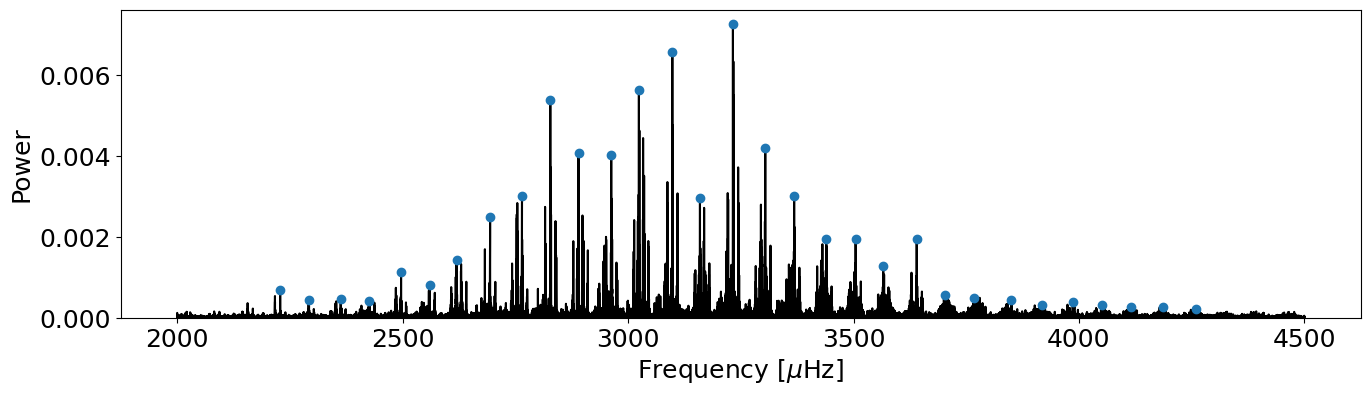

In [44]:
def plot_osc_freq2(f):
    alpha = 0.5
    for x in f:
        plt.axvline(x = x, color = 'g', alpha=alpha)

fig = plt.figure(figsize=(16, 4))
frequency, power = LombScargle(bjd*24*3600, rv).autopower(minimum_frequency=1/600, maximum_frequency=1/200, samples_per_peak=100)
frequency *= 1e6

power_max = []
freq_max = []
for f in freq:
    max_power = max(power[(frequency<f+10)&(frequency>f-10)])
    power_max.append(max_power)
    freq_max.append(frequency[power==max_power])
power_max = np.array(power_max)

idx = ((frequency<4500) & (frequency>2000))
plt.plot(frequency[idx], power[idx], 'k', alpha=1)
plt.plot(freq_max, power_max, 'o')
plt.xlabel(r'Frequency [$\mu$Hz]')
plt.ylabel('Power')
plt.ylim(bottom=0)
# plot_osc_freq2(freq)
plt.show()

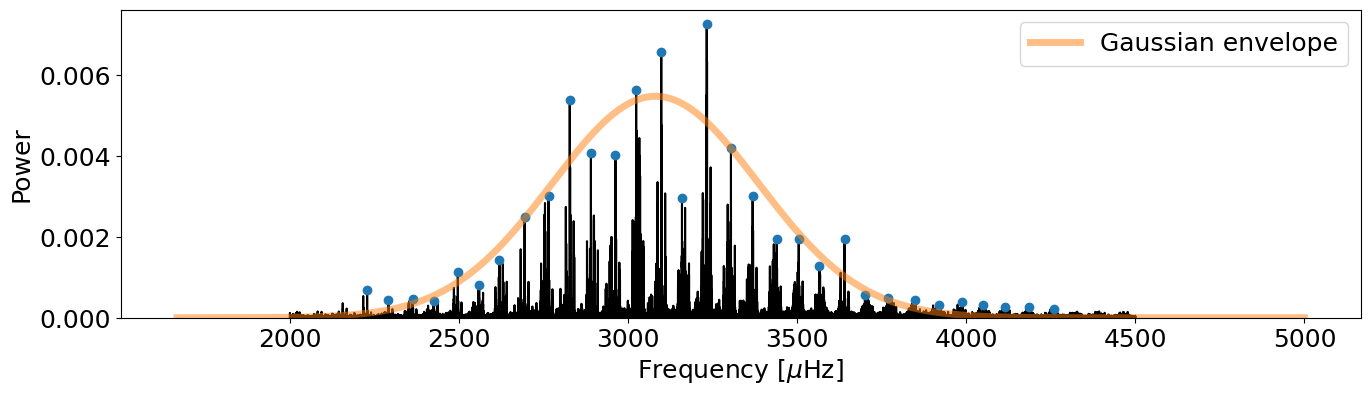

array([ 5.46875972e-03,  3.08082489e+03, -3.05370933e+02])

In [45]:
from scipy.optimize import curve_fit

def gaussian_2(x, amp, mu, sig):
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) 

popt, pcov 		= curve_fit(gaussian_2, freq, power_max, p0=[1, np.mean(freq), 1000])

fig = plt.figure(figsize=(16, 4))
plt.plot(frequency[idx], power[idx], 'k', alpha=1)
plt.plot(freq_max, power_max, 'o')
plt.plot(frequency, gaussian_2(frequency, *popt), lw=5, alpha=0.5, label='Gaussian envelope')
plt.xlabel(r'Frequency [$\mu$Hz]')
plt.ylabel('Power')
plt.ylim(bottom=0)
plt.legend()
# plot_osc_freq2(freq)
# plot_osc_freq()
plt.show()

popt



In [48]:
power_matrix

array([0.00554947, 0.0031112 , 0.00627903, 0.00384331, 0.04818173,
       0.00125313, 0.01482957, 0.05192361, 0.08261549, 0.01531103,
       0.01495811, 0.01375701, 0.00550677, 0.00213001, 0.00988231,
       0.00584746, 0.00313137, 0.00342957, 0.00524883, 0.02705863,
       0.0266916 , 0.09040082, 0.06838542, 0.04426884, 0.01363364,
       0.02880747, 0.0002069 , 0.00628271, 0.00711813, 0.00040148,
       0.00482458])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

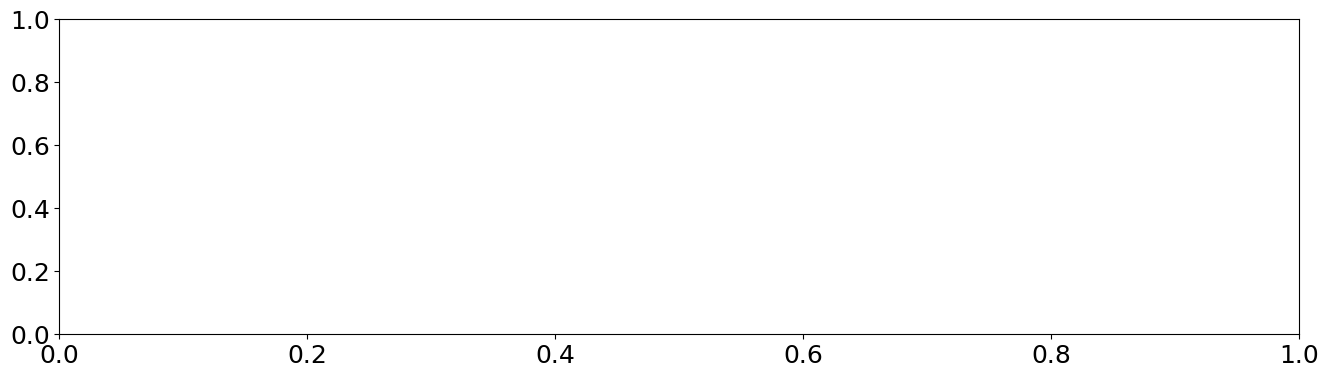

In [46]:
idx_freq = ((freq<3700) & (freq>2600))
# freq_short = freq[idx_freq]

fig = plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 18})
Day = np.array(Day)

fig.add_subplot(211)
for i in range(len(freq[idx_freq])):
    plt.plot(Day-Day[0], power_matrix[:,i], 'o-', alpha=0.5)
plt.ylabel('Power')
plt.ylim([power_matrix.min(), power_matrix.max()*1.05])

fig.add_subplot(212)
for i in range(len(freq[idx_freq])):
    plt.plot(Day-Day[0], power_matrix[:,i], 'o-', alpha=0.5)
plt.xlabel('Day')
plt.ylabel('Power')
plt.ylim([power_matrix.min(), power_matrix.max()*1.05])
plt.yscale('log')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

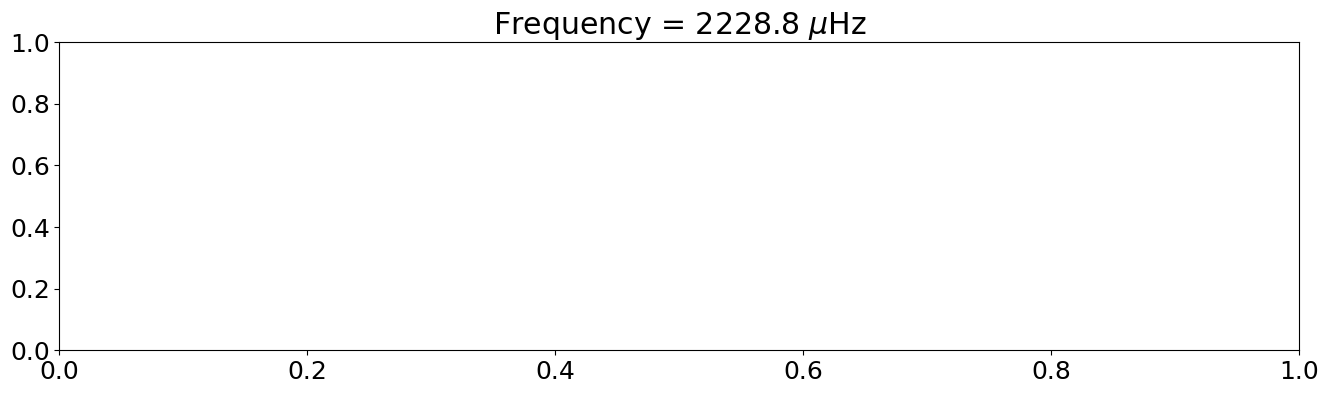

In [47]:
days = Day-Day[0]

for i in range(len(freq)):
    fig = plt.figure(figsize=(16, 4))
    plt.title(r'Frequency = {:.1f} $\mu$Hz'.format(freq[i]))
    plt.plot(days, power_matrix[:,i], 'ko-', alpha=0.9)
    plt.xlabel('Day')
    plt.ylabel('Power')
    plt.ylim([power_matrix.min(), power_matrix.max()*1.05])
    plt.savefig('./Periodogram_power/freq_{:.0f}.png'.format(freq[i]), dpi=300)
#     plt.show()    
    plt.close()

In [ ]:
img_array = []

for filename in glob.glob('./Periodogram_power/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('Video/Periodogram_power.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
day_inter = np.arange(57)
acf_inter = np.zeros((57,len(freq[idx_freq])))
from scipy.interpolate import interp1d
fig = plt.figure(figsize=(16, 4))

for i in range(len(freq[idx_freq])):
    f = interp1d(days, power_matrix[:,i])
    acf_inter[:,i] = sm.tsa.acf(f(day_inter), nlags=len(day_inter), fft=True)
#     acf_inter[:,i] = sm.tsa.acovf(f(day_inter))
plt.plot(day_inter, acf_inter, 'k-', alpha=0.1) 
plt.plot(day_inter, np.mean(acf_inter, axis=1), '-', lw=2, label='mean') 
plt.plot(day_inter, np.median(acf_inter, axis=1), '-', lw=2, label='median')
plt.xlim([1,10])
plt.ylim([-0.4,0.5])
plt.xlabel(r'$\Delta t$ [days]')
plt.ylabel('ACF (max=1)')
# plt.ylim([-0.0002,0.0002])
# ACF = sm.tsa.acovf(pred_mean, fft=True)/(1-Delta_t/max(Delta_t))

plt.show()

In [ ]:
power_matrix.shape

# Test

In [ ]:
def GP_fit(t, y, yerr):
    
    S0 = np.var(y) / (2*np.pi/5 * 3*24*60)
    Q = 3*24*60    
    w0 = 2*np.pi / (1/(freq[0]*1e-6)/60)
    bounds = dict(log_S0=(-25, 15), log_Q=(np.log(3000), np.log(8000)))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    kernel.freeze_parameter("log_omega0")
    
    for fre in freq[1:]:
        w0 = 2*np.pi / (1/(fre*1e-6)/60)
        print(2*np.pi/w0)
#         bounds = dict(log_S0=(-15, 15), log_Q=(np.log(2*24*60), np.log(4*24*60)))
        k = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
        k.freeze_parameter("log_omega0")
        kernel += k

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)

    return gp

### All data

In [ ]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*0.69
    
    gp = GP_fit(t, y, yerr)
#     idx_half = (t > max(t)/2)
#     gp = GP_fit(t[idx_half], y[idx_half], yerr[idx_half])

In [ ]:
x = np.linspace(min(t), max(t), 2000)
idx_half = (t > max(t)/2)
pred_mean, pred_var = gp.predict(y[idx_half], x, return_var=True)
pred_std = np.sqrt(pred_var)   


fig, axs = plt.subplots(4, 1, figsize=(16, 9))
plt.subplots_adjust(hspace=0.3)
axs[0].set_title(str(date)[:10])
for i in range(4):
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    idx_x = ((x>=i*200) & (x<(i+1)*200))
    axs[i].plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    axs[i].plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8)
    axs[i].fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.1,
                     edgecolor="none")
    axs[i].set_ylabel('RV [m/s]')    
    axs[i].set_xlim([i*200, (i+1)*200])
    axs[i].set_ylim([-3.5, 3.5])    
    axs[i].grid(True)
axs[-1].set_xlabel('$t$ [minutes]')
plt.show()


fig = plt.figure(figsize=(16, 4))
pred_mean_t, pred_var = gp.predict(y[idx_half], t, return_var=True)
plt.plot(t, y-pred_mean_t, 'k.', alpha=0.1)
plt.xlabel('$t$ [minutes]')
plt.ylabel('RV residual [m/s]')
plt.show()


In [ ]:
np.std(y-pred_mean_t)

In [ ]:
values = []
for key, value in gp.get_parameter_dict().items():
    print(key[11:], '\t:', np.exp(value))
    values.append(np.exp(value))
values =    np.array(values) 
S0_array = values[::2]
Q_array = values[1::2]/60/24
S0_array, Q_array

In [ ]:
fig = plt.figure(figsize=(16, 4))
frequency, power = LombScargle(t*60, y).autopower(minimum_frequency=1/600, maximum_frequency=1/200, samples_per_peak=100)
frequency *= 1e6
idx = ((frequency<4500) & (frequency>2000))
plt.title(str(date)[:10])
plt.plot(frequency[idx], power[idx], 'k', alpha=0.9)
plt.xlabel(r'Frequency [$\mu$Hz]')
plt.ylabel('Power')
plt.plot(freq, S0_array, 'ro')
plt.ylim(bottom=0)
plot_osc_freq()

# Fix S0

In [ ]:
def GP_fit(t, y, yerr):
    
    S0 = power_matrix[0]
    Q = 3*24*60    
    w0 = 2*np.pi / (1/(freq[0]*1e-6)/60)
    bounds = dict(log_Q=(np.log(3000), np.log(8000)))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    kernel.freeze_parameter("log_omega0")
    kernel.freeze_parameter("log_S0")
    
    for i in range(len(freq)-1):
        w0 = 2*np.pi / (1/(fre[i+1]*1e-6)/60)
        S0 = power_matrix[i+1]
        print(2*np.pi/w0)
#         bounds = dict(log_S0=(-15, 15), log_Q=(np.log(2*24*60), np.log(4*24*60)))
        k = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
        k.freeze_parameter("log_omega0")
        k.freeze_parameter("log_S0")
        kernel += k

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)

    return gp

In [ ]:
power_matrix